# 结合TabNet与GBDT的物联网异常流量检测方法

## 导入包+全局设置

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc #用于内存回收
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
# 全局设置
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## 数据预处理

In [2]:
# 数据处理 
print("清洗数据中")
df = pd.read_csv('IoT_Intrusion.csv')

# 清洗无穷值与缺失值
def clean_dataset(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

df = clean_dataset(df)

# 标签合并
target_col = 'label'
label_group_map = {
    'DDoS-ICMP_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 
    'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS', 
    'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS',
    
    'DoS-UDP_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    
    'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai',
    
    'Recon-HostDiscovery': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
    'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon',
    
    'SqlInjection': 'Web', 'XSS': 'Web', 'Backdoor_Malware': 'Web', 
    'BrowserHijacking': 'Web', 'CommandInjection': 'Web', 'Uploading_Attack': 'Web',
    
    'DictionaryBruteForce': 'BruteForce',
    'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing',
    'BenignTraffic': 'Benign'
}
df[target_col] = df[target_col].map(label_group_map).fillna(df[target_col])

# 标签编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df[target_col])
# 提取特征名称 
feature_names = df.drop(columns=[target_col]).columns.tolist()
X_values = df.drop(columns=[target_col]).values

print(f"标签分布: {Counter(y_encoded)}")
del df # 释放内存
gc.collect()

清洗数据中
标签分布: Counter({2: 763525, 3: 181481, 4: 59233, 0: 24476, 6: 11053, 5: 7945, 7: 538, 1: 324})


0

## 划分数据集

In [3]:
print("切分数据 (Train/Val/Test)")
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    X_values, y_encoded, test_size=0.3, random_state=seed, stratify=y_encoded
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
)

print(f"训练集: {X_train_raw.shape}, 验证集: {X_val_raw.shape}, 测试集: {X_test_raw.shape}")

切分数据 (Train/Val/Test)
训练集: (734002, 46), 验证集: (157286, 46), 测试集: (157287, 46)


## GBDT

In [4]:
print("\nGBDT模型：")

#LightGBM
print("训练 LightGBM： ")
lgbm = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    objective='multiclass',
    class_weight='balanced', 
    random_state=seed,
    n_jobs=-1
)

lgbm.fit(
    X_train_raw, y_train_raw,
    eval_set=[(X_val_raw, y_val)],
    feature_name=feature_names,
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(200)]
)

# XGBoost
print("训练 XGBoost：")
# sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_raw)

xgb_clf = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',
    tree_method='hist',
    device='cuda', 
    random_state=seed,
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_clf.fit(
    X_train_raw, y_train_raw,
    sample_weight=sample_weights, # 传入样本权重处理不平衡
    eval_set=[(X_val_raw, y_val)],
    verbose=200
)



GBDT模型：
训练 LightGBM： 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5325
[LightGBM] [Info] Number of data points in the train set: 734002, number of used features: 40
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
Training until validation score

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...)

## TabNet

In [5]:

#TabNet 分支
#SMOTE混合采样、StandardScaler、预训练
print("\nTabNet：")

#SMOTE + UnderSampling
original_counts = Counter(y_train_raw)
min_limit = 2000   # 小类补到 2000
max_limit = 50000  # 大类砍到 50000

sampling_strategy_over = {cls: min_limit for cls, count in original_counts.items() if count < min_limit}
sampling_strategy_under = {cls: max_limit for cls, count in original_counts.items() if count > max_limit}

# 如果没有需要采样的类，Pipeline 会自动跳过
pipeline_steps = []
if sampling_strategy_over:
    pipeline_steps.append(('o', SMOTE(sampling_strategy=sampling_strategy_over, random_state=seed)))
if sampling_strategy_under:
    pipeline_steps.append(('u', RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=seed)))

if pipeline_steps:
    print("SMOTE + UnderSampling：")
    resample_pipe = Pipeline(steps=pipeline_steps)
    X_train_tab, y_train_tab = resample_pipe.fit_resample(X_train_raw, y_train_raw)
else:
    print("无需重采样")
    X_train_tab, y_train_tab = X_train_raw, y_train_raw

print(f"TabNet 训练集形状: {X_train_tab.shape}")

# 标准化
scaler = StandardScaler()
X_train_tab = scaler.fit_transform(X_train_tab)
X_val_tab = scaler.transform(X_val_raw)
X_test_tab = scaler.transform(X_test_raw)

#TabNet 预训练
tabnet_params = dict(
    n_d=64, n_a=64, n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    device_name='auto'
)

print("TabNet 预训练：")
unsupervised_model = TabNetPretrainer(**tabnet_params)

unsupervised_model.fit(
    X_train=X_train_tab,
    eval_set=[X_val_tab],
    max_epochs=15, # 预训练轮数
    patience=5,
    batch_size=2048, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5
)

# TabNet 分类器
print("训练 TabNet：")
clf_tabnet = TabNetClassifier(**tabnet_params)

clf_tabnet.fit(
    X_train=X_train_tab, y_train=y_train_tab,
    eval_set=[(X_val_tab, y_val)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=15,
    batch_size=2048,
    virtual_batch_size=256,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model # 加载预训练权重
)



TabNet：
SMOTE + UnderSampling：
TabNet 训练集形状: (175894, 46)
TabNet 预训练：


D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: -6685867.27994| val_0_unsup_loss_numpy: 251878.5625|  0:00:27s
epoch 1  | loss: -1119245108.26275| val_0_unsup_loss_numpy: 27120562.0|  0:00:56s
epoch 2  | loss: -7670153265.94863| val_0_unsup_loss_numpy: 1213511936.0|  0:01:23s
epoch 3  | loss: -18439608590.14962| val_0_unsup_loss_numpy: 2799540480.0|  0:01:51s
epoch 4  | loss: -30972791698.12146| val_0_unsup_loss_numpy: 24957145088.0|  0:02:18s
epoch 5  | loss: -48239964502.82758| val_0_unsup_loss_numpy: 11104331776.0|  0:02:44s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 251878.5625
训练 TabNet：


D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.73167 | valid_accuracy: 0.62905 |  0:00:15s
epoch 1  | loss: 0.47758 | valid_accuracy: 0.60382 |  0:00:30s
epoch 2  | loss: 0.45953 | valid_accuracy: 0.6066  |  0:00:44s
epoch 3  | loss: 0.45586 | valid_accuracy: 0.70486 |  0:00:59s
epoch 4  | loss: 0.45345 | valid_accuracy: 0.60943 |  0:01:15s
epoch 5  | loss: 0.2369  | valid_accuracy: 0.81483 |  0:01:30s
epoch 6  | loss: 0.18443 | valid_accuracy: 0.59598 |  0:01:45s
epoch 7  | loss: 0.19676 | valid_accuracy: 0.54074 |  0:02:00s
epoch 8  | loss: 0.18939 | valid_accuracy: 0.80059 |  0:02:15s
epoch 9  | loss: 0.19656 | valid_accuracy: 0.72958 |  0:02:29s
epoch 10 | loss: 0.19733 | valid_accuracy: 0.54651 |  0:02:45s
epoch 11 | loss: 0.18664 | valid_accuracy: 0.56803 |  0:03:00s
epoch 12 | loss: 0.17577 | valid_accuracy: 0.51006 |  0:03:16s
epoch 13 | loss: 0.17201 | valid_accuracy: 0.9273  |  0:03:32s
epoch 14 | loss: 0.18096 | valid_accuracy: 0.69248 |  0:03:47s
epoch 15 | loss: 0.18307 | valid_accuracy: 0.733   |  0

D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 动态权重融合

In [6]:
from scipy.optimize import minimize
from sklearn.metrics import f1_score, log_loss
import shap

# 动态权重融合
print("\n寻找最佳融合权重：")

# 获取验证集上的概率预测 
probs_val_lgbm = lgbm.predict_proba(X_val_raw)
probs_val_xgb = xgb_clf.predict_proba(X_val_raw)
probs_val_tabnet = clf_tabnet.predict_proba(X_val_tab)

# 最小化 Log Loss
def loss_func(weights):
    # 归一化权重 
    weights = np.array(weights)
    weights /= weights.sum()
    
    # 融合概率
    final_probs = (weights[0] * probs_val_lgbm + 
                   weights[1] * probs_val_xgb + 
                   weights[2] * probs_val_tabnet)
    
    final_probs = np.clip(final_probs, 1e-15, 1 - 1e-15)
    
    return log_loss(y_val, final_probs)

# 初始设定：平均分配
init_weights = [1/3, 1/3, 1/3]
bounds = [(0, 1)] * 3
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})

res = minimize(loss_func, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)

best_weights = res.x / res.x.sum()
print(f"最佳权重 -> LGBM: {best_weights[0]:.4f}, XGB: {best_weights[1]:.4f}, TabNet: {best_weights[2]:.4f}")



寻找最佳融合权重：


D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\xgboost\core.py:774: UserWarning: [15:25:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  w

最佳权重 -> LGBM: 0.3338, XGB: 0.3415, TabNet: 0.3247


D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


## 分类指标

In [7]:
probs_test_lgbm = lgbm.predict_proba(X_test_raw)
probs_test_xgb = xgb_clf.predict_proba(X_test_raw)
probs_test_tab = clf_tabnet.predict_proba(X_test_tab)

#加权融合
final_test_probs = (best_weights[0] * probs_test_lgbm + 
                    best_weights[1] * probs_test_xgb + 
                    best_weights[2] * probs_test_tab)

final_preds = np.argmax(final_test_probs, axis=1)

#综合评估指标
acc = accuracy_score(y_test, final_preds)
macro_f1 = f1_score(y_test, final_preds, average='macro')
weighted_f1 = f1_score(y_test, final_preds, average='weighted')

print("融合模型评估:")
print(f"Accuracy    : {acc:.4f}")
print(f"Macro F1    : {macro_f1:.4f} ")
print(f"Weighted F1 : {weighted_f1:.4f} ")
print("-" * 60)
print("详细分类报告:\n")
print(classification_report(y_test, final_preds, target_names=label_encoder.classes_))

D:\ComputerEnvironment\Anaconda\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


融合模型评估:
Accuracy    : 0.9955
Macro F1    : 0.8624 
Weighted F1 : 0.9954 
------------------------------------------------------------
详细分类报告:

              precision    recall  f1-score   support

      Benign       0.93      0.95      0.94      3672
  BruteForce       0.96      0.52      0.68        48
        DDoS       1.00      1.00      1.00    114529
         DoS       1.00      1.00      1.00     27222
       Mirai       1.00      1.00      1.00      8885
       Recon       0.84      0.82      0.83      1192
    Spoofing       0.89      0.87      0.88      1658
         Web       0.69      0.49      0.58        81

    accuracy                           1.00    157287
   macro avg       0.91      0.83      0.86    157287
weighted avg       1.00      1.00      1.00    157287



## 结果可视化分析


SHAP 分析：
LightGBM:


C:\Users\李承宇\AppData\Local\Temp\ipykernel_22704\1583792340.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lgbm, X_shap_raw, feature_names=feature_names, plot_type="bar", show=False)


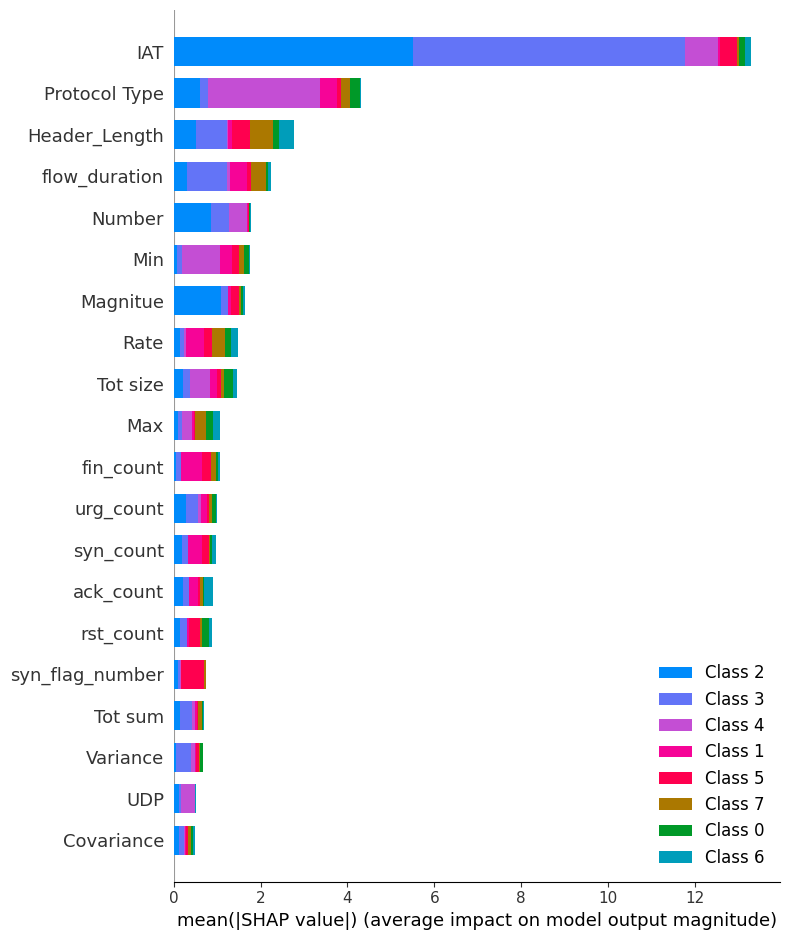

TabNet:


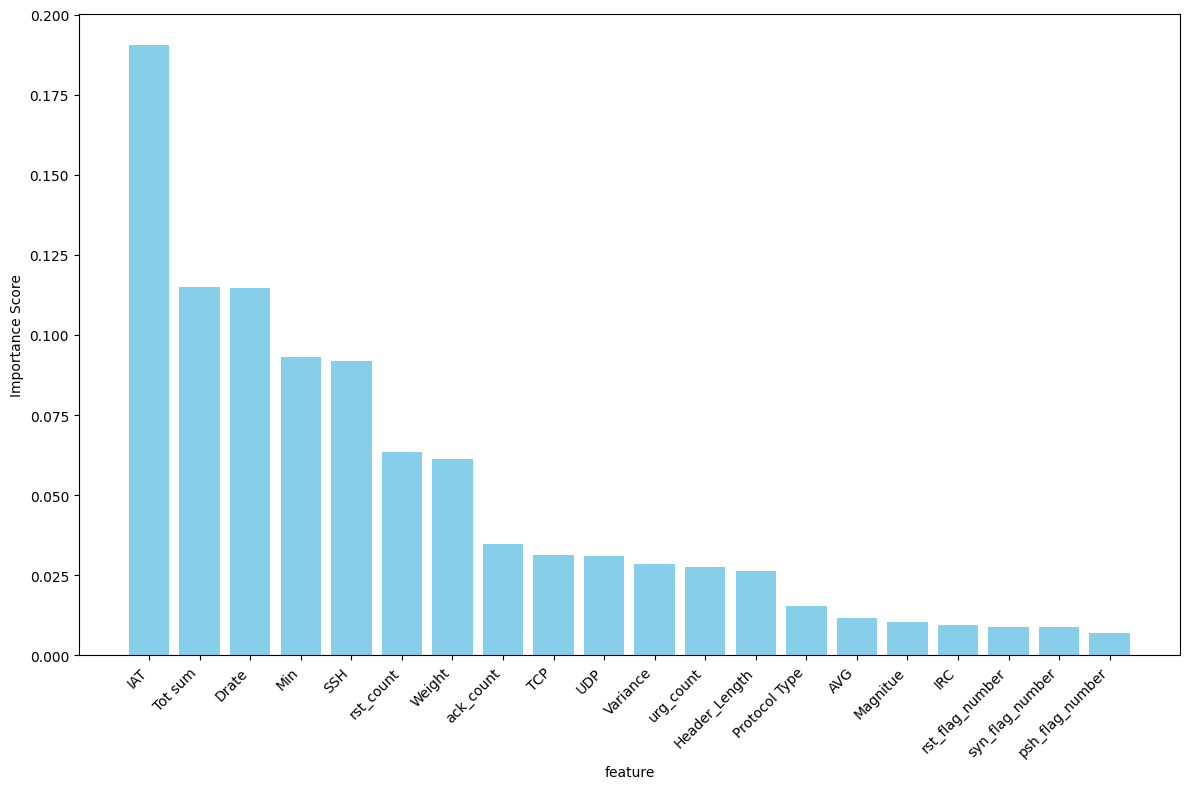

In [9]:
import shap
import matplotlib.pyplot as plt
import os

# SHAP
print("\nSHAP 分析：")

# SHAP 随机抽取样本进行解释
sample_idx = np.random.choice(X_test_raw.shape[0], 1000, replace=False)
X_shap_raw = X_test_raw[sample_idx]
X_shap_tab = X_test_tab[sample_idx] # TabNet 使用标准化后的数据

if not os.path.exists('results'):
    os.makedirs('results')
#LightGBM
print("LightGBM:")
explainer_lgbm = shap.TreeExplainer(lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_shap_raw)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_lgbm, X_shap_raw, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('results/LGBM.png', dpi=300, bbox_inches='tight')
plt.show()
# TabNet
print("TabNet:")
feat_importances = clf_tabnet.feature_importances_
indices = np.argsort(feat_importances)[::-1]

#前 20 个重要特征
top_k = 20
top_indices = indices[:top_k]
top_importances = feat_importances[top_indices]
top_names = [feature_names[i] for i in top_indices]

plt.figure(figsize=(12, 8))
plt.bar(range(top_k), top_importances, align='center', color='skyblue')
plt.xticks(range(top_k), top_names, rotation=45, ha='right')
plt.ylabel("Importance Score")
plt.xlabel("feature")
plt.tight_layout()
plt.savefig('results/TabNet.png', dpi=300, bbox_inches='tight')
plt.show()